<h1>This notebook is an exploration of the structure of the forcing files used for MOHID<h1>
    <ol>
        <li>
            <a href="#winds">Winds</a>
        </li>
        <li>
            <a href="#currents">Currents</a>
        </li>
        <li>
            <a href="#createwind">Create Wind Input file Structure</a>
        </li>
                <li>
            <a href="#createcurrents">Create Current Input file Structure</a>
        </li>
    </ol>

In [1]:
import numpy as np
from tables import * 
import xarray as xr
import datetime as datetime
from salishsea_tools import viz_tools

<div id='winds'><a name='Winds'></a><h2>Winds</h2></div>

In [38]:
h5wind = open_file('/ocean/abhudia/MEOPAR/analysis-ashutosh/temp/st_georgia_wind.hdf5')
for group in h5wind.walk_groups():
    print(group)

/ (RootGroup) ''
/Results (Group) ''
/Time (Group) ''
/Results/wind velocity X (Group) ''
/Results/wind velocity Y (Group) ''


<div id='currents'><a name='Currents'></a><h2>Currents</h2></div>

In [17]:
h5current = open_file('/ocean/abhudia/MEOPAR/analysis-ashutosh/temp/St_georgia.hdf5')
for group in h5current.walk_groups():
    print(group)

/ (RootGroup) ''
/Results (Group) ''
/Time (Group) ''
/Results/velocity U (Group) ''
/Results/velocity V (Group) ''
/Results/water level (Group) ''


In [36]:
for time in getattr(h5current.root.Time, 'Time_00168'):
    print(time)

2015.0
4.0
14.0
22.0
30.0
0.0


In [23]:
a = np.asarray(getattr(getattr(h5current.root.Results, 'velocity U'), 'velocity U_00001'))

In [24]:
a.shape

(40, 396, 896)

<div id='createwind'><a name='Currents'></a><h2>Create wind input file structure</h2></div>

In [48]:
# time is stroed in array ([year, month, day, hour, minutes, seconds])

getattr(h5current.root.Results, 'velocity U')

/Results/velocity U (Group) ''
  children := ['velocity U_00001' (CArray), 'velocity U_00002' (CArray), 'velocity U_00003' (CArray), 'velocity U_00004' (CArray), 'velocity U_00005' (CArray), 'velocity U_00006' (CArray), 'velocity U_00007' (CArray), 'velocity U_00008' (CArray), 'velocity U_00009' (CArray), 'velocity U_00010' (CArray), 'velocity U_00011' (CArray), 'velocity U_00012' (CArray), 'velocity U_00013' (CArray), 'velocity U_00014' (CArray), 'velocity U_00015' (CArray), 'velocity U_00016' (CArray), 'velocity U_00017' (CArray), 'velocity U_00018' (CArray), 'velocity U_00019' (CArray), 'velocity U_00020' (CArray), 'velocity U_00021' (CArray), 'velocity U_00022' (CArray), 'velocity U_00023' (CArray), 'velocity U_00024' (CArray), 'velocity U_00025' (CArray), 'velocity U_00026' (CArray), 'velocity U_00027' (CArray), 'velocity U_00028' (CArray), 'velocity U_00029' (CArray), 'velocity U_00030' (CArray), 'velocity U_00031' (CArray), 'velocity U_00032' (CArray), 'velocity U_00033' (CArray

In [21]:
getattr(getattr(h5wind.root.Results, 'wind velocity X'), 'wind velocity X_00001')

NameError: name 'h5wind' is not defined

In [6]:
class Wind_X(IsDescription):
    array = Float64Atom(shape=(), dflt=0.0)

In [7]:
class Wind_Y(IsDescription):
    array = Float64Atom(shape=(), dflt=0.0)

In [8]:
class Times(IsDescription):
    array = Float64Atom(shape=(), dflt=0.0)

In [9]:
# create hdf5 file
h5file = open_file("temp/winds.h5", mode="w", title="Winds Test file")

In [10]:
times = h5file.create_group("/", 'Time', 'Time')
results = h5file.create_group("/", 'Results', 'Results')
wind_u = h5file.create_group(results, 'wind velocity X', 'wind velocity X')
wind_v = h5file.create_group(results, 'wind velocity Y', 'wind velocity Y')

/home/abhudia/anaconda3/lib/python3.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'wind velocity X'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/home/abhudia/anaconda3/lib/python3.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'wind velocity Y'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


In [44]:
getattr(h5wind.root.Results, ''

/Time/Time_00001 (CArray(6,), zlib(6)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (6,)

In [12]:
wind_arr = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/hrdps/28nov17-05dec17/GEM.nc')

In [13]:
u_arr = wind_arr.u_wind.values

In [14]:
v_arr = wind_arr.v_wind.values

In [15]:
u_arr.shape

(192, 266, 256)

In [ ]:
# write u wind values ot array
for i in range(u_arr.shape[0]):
    h5file.create_carray(wind_u, f'{i}',obj = u_arr[i],shape=(266, 256), chunkshape = (266, 256))

In [17]:
# write u wind values ot array
for i in range(v_arr.shape[0]):
    h5file.create_carray(wind_v, f'{i}',obj = v_arr[i],shape=(266, 256), chunkshape = (266, 256))

In [18]:
for group in h5file.walk_groups():
    print(group)

/ (RootGroup) 'Winds Test file'
/Results (Group) 'Results'
/Time (Group) 'Time'
/Results/wind velocity X (Group) 'wind velocity X'
/Results/wind velocity Y (Group) 'wind velocity Y'


In [29]:
# confirm
np.asarray(getattr(getattr(h5file.root.Results, 'wind velocity X'), '0'))

(266, 256)

<div id='createcurrents'><a name='Currents'></a><h2>Create currents input file structure</h2></div>

In [2]:
U = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/U.nc').isel(time_counter = slice(23,24))
V = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/V.nc').isel(time_counter = slice(23,24))

In [8]:
unstaggered_U  = viz_tools.unstagger_xarray(U.vozocrtx, 'x').values
unstaggered_V  = viz_tools.unstagger_xarray(V.vomecrty, 'y').values
current_u, current_v = viz_tools.rotate_vel(unstaggered_U, unstaggered_V)
datelist = U.time_counter.values.astype('datetime64[s]').astype(datetime.datetime)

In [5]:
# list of dates
datearrays = []
for date in datelist:
    datearrays.append(np.array([date.year, date.month, date.day, date.hour, date.minute, date.second]))

In [ ]:
# make hdf5 fle for currents
h5file = open_file("temp/currents.h5", mode="w", title="Currents Test file")

# make tree structure
times = h5file.create_group("/", 'Time', 'Time')
results = h5file.create_group("/", 'Results', 'Results')
wind_u = h5file.create_group(results, 'velocity U', 'velocity U')
wind_v = h5file.create_group(results, 'velocity V', 'velocity V')

# write u wind values to array
for i in range(current_u.shape[0]):
    velocity_attr = 'velocity U_' + ((5 - len(str(i))) * '0') + str(i)
    h5file.create_carray(current_u, f'{velocity_attr}',obj = current_u[i],shape=(396, 896), chunkshape = (396, 896))

# write v wind values to array
for i in range(current_v.shape[0]):
    velocity_attr = 'velocity V_' + ((5 - len(str(i))) * '0') + str(i)
    h5file.create_carray(current_v, f'{velocity_attr}',obj = current_u[i],shape=(396, 896), chunkshape = (396, 896))
    
# write time values to array
for i in range(len(datearrays)):
    time_attr = 'Time_' + ((5 - len(str(i))) * '0') + str(i)
    h5file.create_carray(times, f'{time_attr}',obj = datearrays[i],shape=(396, 896), chunkshape = (396, 896))

h5file.close()

In [14]:
####Test by making one input


# make hdf5 fle for currents
h5file = open_file("temp/test1.h5", mode="w", title="Currents Test file")

# make tree structure
times = h5file.create_group("/", 'Time', 'Time')
results = h5file.create_group("/", 'Results', 'Results')
wind_u = h5file.create_group(results, 'velocity U', 'velocity U')
wind_v = h5file.create_group(results, 'velocity V', 'velocity V')

# write u wind values to array
for i in range(1):
    velocity_attr = 'velocity U_' + ((5 - len(str(i))) * '0') + str(i)
    h5file.create_carray(current_u, f'{velocity_attr}',obj = current_u[i].T,shape=(396, 896), chunkshape = (396, 896))

# write v wind values to array
for i in range(1):
    velocity_attr = 'velocity V_' + ((5 - len(str(i))) * '0') + str(i)
    h5file.create_carray(current_v, f'{velocity_attr}',obj = current_u[i].T,shape=(396, 896), chunkshape = (396, 896))
    
# write time values to array
for i in range(1):
    time_attr = 'Time_' + ((5 - len(str(i))) * '0') + str(i)
    h5file.create_carray(times, f'{time_attr}',obj = datearrays[i].T,shape=(396, 896), chunkshape = (396, 896))

h5file.close()

TypeError: the shape parameter do not match obj.shape

In [13]:
h5file.close()

In [25]:
#  shape of Shihan's Nemo Grid
a.shape

(40, 396, 896)

In [26]:
# shape of nemo grid
current_u.shape

(1, 40, 898, 398)

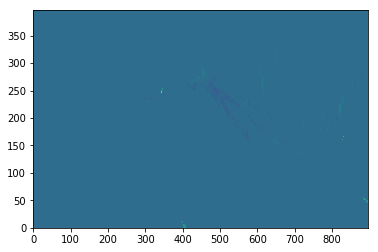

In [32]:
import matplotlib.pyplot as plt
plt.pcolormesh(a[6])

In [ ]:
# units also

In [38]:
np.nansum(a[1])

1.9407642514104282

In [37]:
np.nansum(current_u[0][1])

7694.7485